<a href="https://colab.research.google.com/github/Mario-td/Hand-Gesture-Classification-with-Tensorflow-2.0/blob/master/3DModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D model selection**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the files
path = '/content/drive/My Drive/MastersThesis/Dataset/'
train3D = pd.read_csv(path + '/TrainingSet3D.csv')
test3D = pd.read_csv(path + '/TestSet3D.csv')

In [ ]:
# Gets the number of frames per sample
t_steps = max(test3D['Sequence']) + 1
t_steps

32

In [ ]:
# Gets the labels
Y_train3D = np.array(train3D['Label'][0::t_steps][:], dtype=np.int32)
Y_test3D = np.array(test3D['Label'][0::t_steps][:], dtype=np.int32)

In [ ]:
# Gets the data
X_train3D = pd.DataFrame.to_numpy(train3D[train3D.columns[2:]])
X_test3D = pd.DataFrame.to_numpy(test3D[test3D.columns[2:]])
# Splits into the number of samples
X_train3D = np.array(np.split(X_train3D, Y_train3D.size))
X_test3D = np.array(np.split(X_test3D, Y_test3D.size))

In [ ]:
# Splits into training, and validation set
X_train3D, X_val3D, Y_train3D, Y_val3D = train_test_split(X_train3D, Y_train3D,
                                                test_size=0.1, random_state=42)

In [ ]:
print('X_train3D shape ' + str(X_train3D.shape))
print('Y_train3D shape ' + str(Y_train3D.shape))
print('X_val3D shape ' + str(X_val3D.shape))
print('Y_val3D shape ' + str(Y_val3D.shape))

X_train3D shape (3137, 32, 63)
Y_train3D shape (3137,)
X_val3D shape (349, 32, 63)
Y_val3D shape (349,)


# **Data augmentation**

In [ ]:
def dataAugmentation(X_, Y, c):
    X = X_[Y == c]
    # Duplicate the samples by inverting the order of the sequence in time
    X_inv_t = [X[i][::-1] for i in range(len(X))]
    X = np.append(X, X_inv_t, 0)
    # Duplicate the samples by inverting the x coordinate
    # with respect to the y axis (mirroring)
    X_inv_pos = []
    for k in range(len(X)):
        Xj = []
        for j in range(len(X[k])):
            Xi = []
            for i in range(len(X[k][j])):
                if i % 3 == 0:
                    Xi.append(abs(X[k][j][i] - 1))
                else:
                    Xi.append(X[k][j][i])
            Xj.append(Xi)
        X_inv_pos.append(Xj)
    X = np.append(X, X_inv_pos, 0)
    X_ = np.append(X_[Y != c], X, 0)
    Y = np.append(Y[Y != c], np.ones(len(X)) * c)
    return X_, Y

In [ ]:
# Duplicate samples of class 0 in training, validation and test sets
# separately to avoid overfitting mixing samples
for c in range(5):
    X_train3D, Y_train3D = dataAugmentation(X_train3D, Y_train3D, c)
    X_val3D, Y_val3D = dataAugmentation(X_val3D, Y_val3D, c)
    X_test3D, Y_test3D = dataAugmentation(X_test3D, Y_test3D, c)

In [ ]:
# Prints the number of samples per class in the training and test set
n_classes = 5
for i in range(n_classes):
    print('train samples %d: ' % i + str(np.count_nonzero(Y_train3D == i)))
print('----------------------')
for i in range(n_classes):
    print('val samples %d: ' % i + str(np.count_nonzero(Y_val3D == i)))
print('----------------------')
for i in range(n_classes):
    print('test samples %d: ' % i + str(np.count_nonzero(Y_test3D == i)))

train samples 0: 2524
train samples 1: 2432
train samples 2: 2480
train samples 3: 2464
train samples 4: 2648
----------------------
val samples 0: 324
val samples 1: 276
val samples 2: 268
val samples 3: 224
val samples 4: 304
----------------------
test samples 0: 288
test samples 1: 284
test samples 2: 300
test samples 3: 288
test samples 4: 288


In [ ]:
# Adjusts the label arrays shape
Y_train3D = tf.keras.utils.to_categorical(Y_train3D, n_classes)
Y_test3D = tf.keras.utils.to_categorical(Y_test3D, n_classes)
Y_val3D = tf.keras.utils.to_categorical(Y_val3D, n_classes)

In [ ]:
# Number of input parameters per timestep
n_input3D = len(X_train3D[0][0])
# Reshapes the input splitting it into subsequences
n_sub = 2
n_length = int(t_steps / n_sub)
X_train3D = X_train3D.reshape((X_train3D.shape[0], n_sub, n_length, n_input3D))
X_val3D = X_val3D.reshape((X_val3D.shape[0], n_sub, n_length, n_input3D))
X_test3D = X_test3D.reshape((X_test3D.shape[0], n_sub, n_length, n_input3D))

In [ ]:
# Defines the model
model_3D = tf.keras.Sequential()
model_3D.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_sub, n_length, n_input3D)))
model_3D.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model_3D.add(tf.keras.layers.Dropout(0.2))
model_3D.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)))
model_3D.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model_3D.add(tf.keras.layers.LSTM(200))
model_3D.add(tf.keras.layers.Dropout(0.2))
model_3D.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

# **Model training**

In [ ]:
# Hyperparameters
batch_size = 1024
n_epochs = 70
opt = tf.keras.optimizers.Adam(learning_rate=0.0011, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_3D.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Measures the training time
t_start = time.time()
history = model_3D.fit(X_train3D, Y_train3D, validation_data=(X_val3D, Y_val3D),
                       shuffle=True, batch_size=batch_size, epochs=n_epochs)
t_stop = time.time()
print("Training time: " + str(datetime.timedelta(seconds=t_stop - t_start)))

Epoch 1/70
13/13 [==============================] - 3s 229ms/step - loss: 1.5356 - accuracy: 0.3254 - val_loss: 1.3167 - val_accuracy: 0.5466
Epoch 2/70
13/13 [==============================] - 3s 196ms/step - loss: 1.1060 - accuracy: 0.5763 - val_loss: 0.8436 - val_accuracy: 0.6533
Epoch 3/70
13/13 [==============================] - 3s 195ms/step - loss: 0.7980 - accuracy: 0.6760 - val_loss: 0.7194 - val_accuracy: 0.7128
Epoch 4/70
13/13 [==============================] - 3s 195ms/step - loss: 0.6856 - accuracy: 0.7182 - val_loss: 0.6275 - val_accuracy: 0.7600
Epoch 5/70
13/13 [==============================] - 3s 195ms/step - loss: 0.5994 - accuracy: 0.7771 - val_loss: 0.5575 - val_accuracy: 0.7980
Epoch 6/70
13/13 [==============================] - 3s 195ms/step - loss: 0.5586 - accuracy: 0.7941 - val_loss: 0.5047 - val_accuracy: 0.8295
Epoch 7/70
13/13 [==============================] - 3s 195ms/step - loss: 0.5310 - accuracy: 0.7878 - val_loss: 0.4740 - val_accuracy: 0.8560
Epoch 

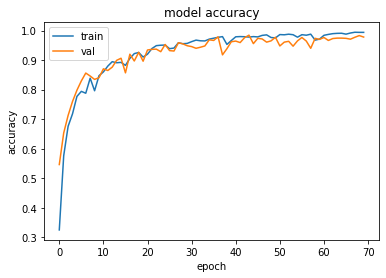

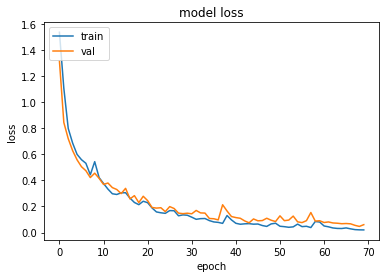

In [ ]:
# Summarizes history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarizes history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Model evaluation**

In [ ]:
# Evaluates the model with the test set
model_3D.evaluate(X_test3D, Y_test3D)

46/46 [==============================] - 0s 4ms/step - loss: 0.1084 - accuracy: 0.9572


[0.10835601389408112, 0.9571823477745056]

In [ ]:
predicted_classes = model_3D.predict_classes(X_test3D)
# Sets the actual test label with the same format
Y_test3D = Y_test3D.argmax(1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


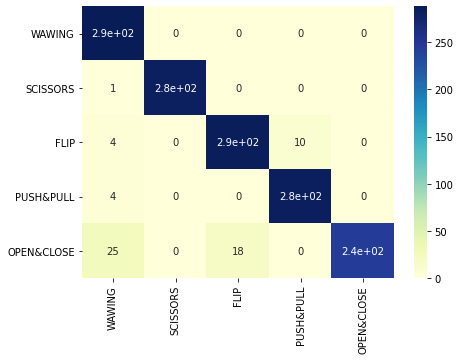

In [ ]:
# Label of the classes
LABELS = [
    'WAWING',
    'SCISSORS',
    'FLIP',
    'PUSH&PULL',
    'OPEN&CLOSE'
]

cm = confusion_matrix(Y_test3D, predicted_classes)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, cmap="YlGnBu")